# **Fase 2: Preprocesamiento e Ingeniería de Características**
Esta fase marca la transición del análisis a la preparación. Partiendo de nuestro DataFrame limpio y explorado (df_final), el objetivo principal de esta fase es realizar la transformación final de los datos para que puedan ser interpretados por algoritmos de Machine Learning.

Las tareas clave que realizaremos son:



1.   **Ingeniería de Características (Feature Engineering)**: Crearemos nuevas variables a partir de las existentes para potenciar la capacidad predictiva del modelo. La creación del Índice de Masa Corporal (IMC) es un ejemplo perfecto.

2.   **Preprocesamiento Estructurado con Pipelines**: Construiremos Pipelines de Scikit-learn para estandarizar las variables numéricas y codificar las categóricas. Este enfoque garantiza que el tratamiento de los datos sea consistente, reproducible y evita errores comunes como la fuga de datos (data leakage).

Al final de esta fase, tendremos nuestros conjuntos de datos de entrenamiento y prueba listos, en un formato puramente numérico, optimizados para la construcción de modelos en la Fase 3.

# 0.- Importar librerias

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np
from typing import Tuple, Any

# Ignorar warning
import warnings
warnings.filterwarnings('ignore')

# Preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


# 0.- Funciones

In [2]:
def calcular_imc(df: pd.DataFrame) -> pd.DataFrame:
  """
  Calcula el Índice de Masa Corporal (IMC) y lo añade como una nueva columna.

  Args:
      df (pd.DataFrame): El DataFrame de entrada que contiene 'weight' y 'height'.

  Returns:
      pd.DataFrame: El DataFrame con la nueva columna 'imc'.
  """
  # Se crea una copia para no modificar el DataFrame original
  df_copy = df.copy()

  # Verificar que las columnas necesarias existan
  if 'weight' in df_copy.columns and 'height' in df_copy.columns:
      df_copy['imc'] = df_copy['weight'] / (df_copy['height'] ** 2)
      print("Columna 'imc' creada exitosamente.")
  else:
      print("Advertencia: No se encontraron las columnas 'weight' y/o 'height'. La columna 'imc' no fue creada.")

  return df_copy

In [3]:
def preparar_datos_para_modelado(
    df: pd.DataFrame,
    target_column: str,
    test_size: float = 0.2,
    random_state: int = 1
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, ColumnTransformer]:
  """
  Prepara los datos para el modelado de Machine Learning.

  Esta función realiza los siguientes pasos:
  1.  Separa las características (X) y la variable objetivo (y).
  2.  Divide los datos en conjuntos de entrenamiento y prueba de forma estratificada.
  3.  Crea un preprocesador (ColumnTransformer) con pipelines para variables
      numéricas (imputación + escalado) y categóricas (imputación + one-hot encoding).
  4.  Ajusta (fits) el preprocesador SÓLO con los datos de entrenamiento para evitar fuga de datos.

  Args:
      df (pd.DataFrame): El DataFrame limpio y con ingeniería de características.
      target_column (str): El nombre de la columna objetivo.
      test_size (float, optional): La proporción del dataset a reservar para la prueba. Defaults to 0.2.
      random_state (int, optional): Semilla para la reproducibilidad de la división. Defaults to 42.

  Returns:
      Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, ColumnTransformer]:
      Un tuple que contiene:
          - X_train: Características de entrenamiento.
          - X_test: Características de prueba.
          - y_train: Variable objetivo de entrenamiento.
          - y_test: Variable objetivo de prueba.
          - preprocesador: El objeto ColumnTransformer ya ajustado a los datos de entrenamiento.
  """
  print("Iniciando la preparación de datos para el modelado...")

  # 1. Separar variables predictoras (X) y variable objetivo (y)
  X = df.drop(target_column, axis=1)
  y = df[target_column]

  # 2. Dividir en conjuntos de entrenamiento y prueba de forma estratificada
  X_train, X_test, y_train, y_test = train_test_split(
      X, y,
      test_size=test_size,
      random_state=random_state,
      stratify=y
  )
  print(f"Datos divididos: {len(X_train)} para entrenamiento, {len(X_test)} para prueba.")

  # 3. Identificar columnas numéricas y categóricas desde el conjunto de entrenamiento
  num_cols = X_train.select_dtypes(include=np.number).columns
  cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

  # 4. Crear los pipelines de preprocesamiento
  pipeline_numerico = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='median')),
      ('scaler', StandardScaler())
  ])

  pipeline_categorico = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='most_frequent')),
      ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
  ])

  # 5. Unir los pipelines en el ColumnTransformer
  preprocesador = ColumnTransformer(
      transformers=[
          ('num', pipeline_numerico, num_cols),
          ('cat', pipeline_categorico, cat_cols)
      ],
      remainder='passthrough'
  )

  # 6. Ajustar el preprocesador SÓLO con los datos de entrenamiento para evitar data leakage
  preprocesador.fit(X_train)

  print("\nPreprocesador creado y ajustado a los datos de entrenamiento exitosamente.")

  return X_train, X_test, y_train, y_test, preprocesador

# 0.- Importar datos

In [4]:
# Cargar el archivo CSV `obesity_estimation_original.csv` desde Google Drive en un DataFrame de pandas.
file_path = '/content/drive/MyDrive/Maestría MNA/Trimestre 4 Sep-Dic 25/Operaciones de aprendizaje automático/Edén/Proyecto/df_fase1.csv'
df = pd.read_csv(file_path)
df.head()


,gender,age,height,weight,family_history_with_overweight,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,nobeyesdad
0,female,21.0,1.62,64.0,yes,no,2.0,3.0,sometimes,no,2.0,no,0.0,1.0,no,public_transportation,1
1,female,21.0,1.52,56.0,yes,no,3.0,3.0,sometimes,yes,3.0,yes,3.0,0.0,sometimes,public_transportation,1
2,male,23.0,1.80,77.0,yes,no,2.0,3.0,sometimes,no,2.0,no,2.0,1.0,frequently,public_transportation,1
3,male,27.0,1.80,87.0,no,no,3.0,3.0,sometimes,no,2.0,no,2.0,0.0,frequently,walking,2
4,male,22.0,1.78,89.8,no,no,2.0,1.0,sometimes,no,2.0,no,0.0,0.0,sometimes,public_transportation,3


# **1.- Ingeniería de Características (Feature Engineering)**

In [5]:
# Definir la variable objetivo
variable_objetivo = 'nobeyesdad'

# Llama a la función
df_modelo = calcular_imc(df)
df_modelo.head()

Columna 'imc' creada exitosamente.


,gender,age,height,weight,family_history_with_overweight,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,nobeyesdad,imc
0,female,21.0,1.62,64.0,yes,no,2.0,3.0,sometimes,no,2.0,no,0.0,1.0,no,public_transportation,1,24.386526
1,female,21.0,1.52,56.0,yes,no,3.0,3.0,sometimes,yes,3.0,yes,3.0,0.0,sometimes,public_transportation,1,24.238227
2,male,23.0,1.80,77.0,yes,no,2.0,3.0,sometimes,no,2.0,no,2.0,1.0,frequently,public_transportation,1,23.765432
3,male,27.0,1.80,87.0,no,no,3.0,3.0,sometimes,no,2.0,no,2.0,0.0,frequently,walking,2,26.851852
4,male,22.0,1.78,89.8,no,no,2.0,1.0,sometimes,no,2.0,no,0.0,0.0,sometimes,public_transportation,3,28.342381


# **2. Preprocesamiento con Pipelines**

In [6]:
X_train, X_test, y_train, y_test, preprocesador = preparar_datos_para_modelado(df_modelo, variable_objetivo, 0.2, 1)

Iniciando la preparación de datos para el modelado...
Datos divididos: 1556 para entrenamiento, 390 para prueba.

Preprocesador creado y ajustado a los datos de entrenamiento exitosamente.


# **Fase 3: Construcción, Ajuste y Evaluación de Modelos**
En las fases anteriores, exploramos, limpiamos y transformamos nuestros datos, culminando en la creación de un preprocesador robusto. Ahora, utilizaremos estos activos para el objetivo final: **construir y evaluar modelos predictivos.** Nos enfocaremos en:


1.   **Selección de Algoritmos:** Comenzaremos con modelos base simples y progresaremos hacia algoritmos de ensamble más complejos para establecer un benchmark de rendimiento.
2.   **Entrenamiento Sistemático:** Crearemos un framework reutilizable para entrenar cada modelo, garantizando que todos sean evaluados bajo las mismas condiciones.
3.  **Ajuste de Hiperparámetros:** Optimizaremos el mejor modelo candidato para exprimir su máximo potencial predictivo.
4.   **Evaluación Profunda:** Analizaremos el rendimiento del modelo final utilizando métricas detalladas y visualizaciones como la matriz de confusión, conectando los resultados con el problema de negocio.

Esta es la etapa donde la ciencia de datos se encuentra con la ingeniería para producir una solución precisa y eficiente que pueda resolver el problema planteado.

# 0.- Importar librerias

In [7]:
# Modelos de clasificación a evaluar
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Busca de mejores hiperparametros
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Métricas de rendimiento
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Dict


In [12]:
# Definir los modelos y los hiperparámetros a probar para cada uno
configuracion_modelos = [
    {
        'nombre': 'Regresión Logística',
        'modelo': LogisticRegression(max_iter=2000, random_state=11),
        'parametros': {
            'clasificador__penalty': ['l1', 'l2'],
            'clasificador__solver': ['liblinear', 'saga', 'lbfgs'], # Elige el algoritmo para encontrar los coeficientes óptimos.
            'clasificador__C': [0.01, 0.1, 1.0, 10.0] # Controla la intensidad de la regularización. Valores más bajos (más fuerza de regularización) reducen el sobreajuste al penalizar coeficientes grandes. 0.01, 0.1, 1, 10
        }
    },
    {
        'nombre': 'Árbol de Decisión',
        'modelo': DecisionTreeClassifier(random_state=11),
        'parametros': {
            'clasificador__criterion': ['gini', 'entropy', 'log_loss'],
            'clasificador__max_depth': [5, 10, 20, None], # Controla la profundidad máxima del árbol. Valores más bajos limitan la complejidad del modelo, reduciendo el sobreajuste.
            'clasificador__min_samples_split': [2, 5, 10], # Define el número mínimo de muestras requeridas para dividir un nodo interno. Valores más altos evitan el sobreajuste.
            'clasificador__min_samples_leaf': [1, 5, 10], # Define el número mínimo de muestras requeridas para que un nodo sea una hoja (nodo final). Valores más altos evitan sobreajuste.
            'clasificador__max_leaf_nodes': [5, 10, 20] # Define el número máximo de hojas que puede tener el árbol. Limita directamente el tamaño del árbol, reduciendo el sobreajuste.
        }
    },
    {
        'nombre': 'Random Forest',
        'modelo': RandomForestClassifier(random_state=11),
        'parametros': {
            'clasificador__criterion': ['gini', 'entropy', 'log_loss'],
            'clasificador__n_estimators': [100, 200],
            'clasificador__max_depth': [5, 10, 20, None],
            'clasificador__min_samples_split': [2, 5, 10],
            'clasificador__min_samples_leaf': [1, 5, 10],
            #'clasificador__max_leaf_nodes': [5, 10, 20]
        }
    },
    {
        'nombre': 'XGBoost',
        'modelo': XGBClassifier(random_state=11, eval_metric='mlogloss'),
        'parametros': {
            'clasificador__n_estimators': [100, 200],
            'clasificador__max_depth': [5, 7, 10], # Reduce profundidad para evitar overfitting
            'clasificador__learning_rate': [0.001, 0.01, 0.1], # Mantiene estabilidad
            'clasificador__subsample': [0.7, 0.8, 0.9, 1], # Reduce overfitting
            'clasificador__colsample_bytree': [0.7, 0.8, 0.9, 1], # Reduce la cantidad de features usadas por árbol

        }
    },
    {
        'nombre': 'KNN',
        'modelo': KNeighborsClassifier(),
        'parametros': {
            'clasificador__n_neighbors': [3, 5, 7, 10, 15, 20, 30, 50],
            'clasificador__weights': ['uniform', 'distance'],
            'clasificador__metric': ['euclidean', 'manhattan', 'minkowski']
        }
    },
    {
        'nombre': 'MLP',
        'modelo': MLPClassifier(random_state=11, early_stopping=True),
        'parametros': {
            'clasificador__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100), (150,150)], # Define la arquitectura de la red neuronal
            'clasificador__activation': ['relu', 'tanh', 'logistic'], # Define la función de activación
            'clasificador__solver': ['adam', 'sgd'], # Define el algoritmo de optimización
            'clasificador__alpha': [0.0001, 0.001, 0.01], # Controla la regularización L2
            'clasificador__learning_rate': ['constant', 'adaptive'], # Define la tasa de aprendizaje
        }
    },
    {
        'nombre': 'SVM',
        'modelo': SVC(random_state=11),
        'parametros': {
            'clasificador__C': [0.01, 0.1, 1.0, 10.0], # Controla la penalización por errores de clasificación. Valores más bajos (mayor regularización) reducen el sobreajuste.
            'clasificador__gamma': [0.001, 0.01, 0.1, 1.0], # Controla el alcance de la influencia de un solo punto de entrenamiento. Valores más bajos (menor influencia) reducen el sobreajuste.
            'clasificador__kernel': ['linear', 'rbf', 'poly', 'sigmoid'], # Define el tipo de kernel a utilizar
        }
    }
]

In [13]:
def optimizar_y_comparar_modelos(
    config_modelos: list,
    preprocesador,
    X_train, y_train, X_test, y_test
) -> Tuple[pd.DataFrame, dict]:
  """
  Automatiza la optimización y evaluación de múltiples modelos de clasificación.

  Para cada modelo en la configuración, realiza una búsqueda de hiperparámetros
  con GridSearchCV, evalúa el mejor modelo encontrado en el conjunto de prueba
  y devuelve una tabla comparativa.

  Args:
      config_modelos (list): Lista de diccionarios con la configuración de cada modelo.
      preprocesador: El ColumnTransformer para preprocesar los datos.
      X_train, y_train, X_test, y_test: Conjuntos de datos divididos.

  Returns:
      Tuple[pd.DataFrame, dict]:
          - Un DataFrame con los resultados de rendimiento de cada modelo optimizado.
          - Un diccionario con los mejores pipelines entrenados para cada modelo.
  """
  resultados_optimizados = []
  mejores_pipelines = {}

  for config in config_modelos:
      nombre_modelo = config['nombre']
      print(f"--- Optimizando: {nombre_modelo} ---")

      # Crear el pipeline completo
      pipeline = Pipeline(steps=[
          ('preprocesador', preprocesador),
          ('clasificador', config['modelo'])
      ])

      # Configurar y ejecutar GridSearchCV
      grid_search = GridSearchCV(
          pipeline,
          config['parametros'],
          cv=5,  # 5-fold cross-validation
          scoring='f1_weighted',
          n_jobs=-1,
          verbose=1
      )
      grid_search.fit(X_train, y_train)

      # Guardar el mejor pipeline encontrado
      mejor_pipeline = grid_search.best_estimator_
      mejores_pipelines[nombre_modelo] = mejor_pipeline

      # Evaluar en el conjunto de entrenamiento
      predicciones_train = mejor_pipeline.predict(X_train)
      accuracy_train = accuracy_score(y_train, predicciones_train)
      f1_train = f1_score(y_train, predicciones_train, average='weighted')

      # Evaluar en el conjunto de prueba
      predicciones_test = mejor_pipeline.predict(X_test)
      accuracy_test = accuracy_score(y_test, predicciones_test)
      f1_test = f1_score(y_test, predicciones_test, average='weighted')

      # Guardar resultados
      resultados_optimizados.append({
          'Modelo': nombre_modelo,
          'Mejores Parámetros': grid_search.best_params_,
          'F1-Score (Train)': f1_train,
          'Accuracy (Train)': accuracy_train,
          'F1-Score (Test)': f1_test,
          'Accuracy (Test)': accuracy_test
      })

      print(f"Mejor F1-Score (CV) para {nombre_modelo}: {grid_search.best_score_:.4f}\n")
      print(f"Mejores parametros: {grid_search.best_params_}\n")

  # Mostrar la tabla de resultados finales
  print("\n--- Tabla Comparativa de Modelos Optimizados ---")
  display(pd.DataFrame(resultados_optimizados).sort_values(by='F1-Score (Test)', ascending=False))

  return pd.DataFrame(resultados_optimizados), mejores_pipelines

In [14]:
def evaluar_mejor_modelo(
    df_resultados: pd.DataFrame,
    pipelines: Dict[str, Pipeline],
    X_test: pd.DataFrame,
    y_test: pd.Series
) -> Pipeline:
  """
  Seleccionar el mejor modelo basado en el F1-Score, realiza una evaluación
  detallada en el conjunto de prueba y grafica su matriz de confusión.

  Args:
      df_resultados (pd.DataFrame): DataFrame con los resultados de los modelos optimizados.
      pipelines (Dict[str, Pipeline]): Diccionario con los pipelines entrenados y optimizados.
      X_test (pd.DataFrame): Características del conjunto de prueba.
      y_test (pd.Series): Variable objetivo del conjunto de prueba.

  Returns:
      Pipeline: El objeto del pipeline del mejor modelo, listo para ser usado o guardado.
  """
  # 1. Seleccionar el mejor modelo basado en el F1-Score más alto
  mejor_modelo_nombre = df_resultados.loc[df_resultados['F1-Score (Test)'].idxmax()]['Modelo']
  mejor_modelo_pipeline = pipelines[mejor_modelo_nombre]

  print(f"El mejor modelo seleccionado es: {mejor_modelo_nombre}")

  # 2. Realizar predicciones finales con el mejor modelo
  predicciones_finales = mejor_modelo_pipeline.predict(X_test)

  # 3. Imprimir el reporte de clasificación detallado
  print(f"\n--- Reporte de Clasificación Final para: {mejor_modelo_nombre} ---")
  print(classification_report(y_test, predicciones_finales))

  # 4. Visualizar la Matriz de Confusión
  print("\n--- Matriz de Confusión ---")
  cm = confusion_matrix(y_test, predicciones_finales, labels=mejor_modelo_pipeline.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mejor_modelo_pipeline.classes_)

  fig, ax = plt.subplots(figsize=(8, 8))
  disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
  ax.set_title(f"Matriz de Confusión - {mejor_modelo_nombre} (Optimizado)", fontsize=10)
  plt.show()

  return mejor_modelo_pipeline

In [15]:
# Ejecutar el proceso de optimización y comparación
df_resultados_opt, pipelines_optimizados = optimizar_y_comparar_modelos(
    configuracion_modelos,
    preprocesador,
    X_train, y_train, X_test, y_test
)

--- Optimizando: Regresión Logística ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejor F1-Score (CV) para Regresión Logística: 0.9341

Mejores parametros: {'clasificador__C': 1.0, 'clasificador__penalty': 'l1', 'clasificador__solver': 'saga'}

--- Optimizando: Árbol de Decisión ---
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Mejor F1-Score (CV) para Árbol de Decisión: 0.9569

Mejores parametros: {'clasificador__criterion': 'entropy', 'clasificador__max_depth': 10, 'clasificador__max_leaf_nodes': 20, 'clasificador__min_samples_leaf': 1, 'clasificador__min_samples_split': 2}

--- Optimizando: Random Forest ---
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Mejor F1-Score (CV) para Random Forest: 0.9768

Mejores parametros: {'clasificador__criterion': 'entropy', 'clasificador__max_depth': 10, 'clasificador__min_samples_leaf': 1, 'clasificador__min_samples_split': 2, 'clasificador__n_estimators': 200}

--- Optimizando: XGBoost ---


,Modelo,Mejores Parámetros,F1-Score (Train),Accuracy (Train),F1-Score (Test),Accuracy (Test)
3,XGBoost,"{'clasificador__colsample_bytree': 0.7, 'clasi...",1.000000,1.000000,0.969344,0.969231
2,Random Forest,"{'clasificador__criterion': 'entropy', 'clasif...",0.999357,0.999357,0.953934,0.953846
1,Árbol de Decisión,"{'clasificador__criterion': 'entropy', 'clasif...",0.967849,0.967866,0.938111,0.938462
6,SVM,"{'clasificador__C': 10.0, 'clasificador__gamma...",0.997429,0.997429,0.918715,0.917949
0,Regresión Logística,"{'clasificador__C': 1.0, 'clasificador__penalt...",0.957651,0.957584,0.917716,0.917949
5,MLP,"{'clasificador__activation': 'logistic', 'clas...",0.951545,0.951799,0.904537,0.905128
4,KNN,"{'clasificador__metric': 'manhattan', 'clasifi...",1.000000,1.000000,0.904069,0.905128


In [23]:
import pandas as pd
import joblib
import os
from typing import Text, Dict, Any
base_path = '/content/drive/MyDrive/Maestría MNA/Trimestre 4 Sep-Dic 25/Operaciones de aprendizaje automático/Edén/Proyecto/'
pipelines_name = 'pipelines_optimizados.joblib'
ruta_pipelines = os.path.join(base_path, pipelines_name)
joblib.dump(pipelines_optimizados, ruta_pipelines)
ruta_pipelines

'/content/drive/MyDrive/Maestría MNA/Trimestre 4 Sep-Dic 25/Operaciones de aprendizaje automático/Edén/Proyecto/pipelines_optimizados.joblib'

In [20]:
import joblib

output_path = '/content/drive/MyDrive/Maestría MNA/Trimestre 4 Sep-Dic 25/Operaciones de aprendizaje automático/Edén/Proyecto/'

joblib.dump(pipelines_optimizados, output_path)

IsADirectoryError: [Errno 21] Is a directory: '/content/drive/MyDrive/Maestría MNA/Trimestre 4 Sep-Dic 25/Operaciones de aprendizaje automático/Edén/Proyecto/'

In [ ]:
pipelines_optimizados.to_csv(output_path + nombre_archivo + '.csv', index=False)

In [ ]:
import pandas as pd
import joblib
import os
from typing import Text, Dict, Any

def guardar_artefactos_ml(
    df_resultados: pd.DataFrame,
    pipelines: Dict[str, Any],
    base_path: Text = '../../artefactos/',
    results_name: Text = 'mejores_modelos.csv',
    pipelines_name: Text = 'pipelines_optimizados.joblib'
) -> None:
    """
    Guarda los resultados de la optimización y los modelos (pipelines) entrenados.

    Crea un directorio de destino si no existe.

    Args:
        df_resultados (pd.DataFrame): DataFrame con la tabla comparativa de modelos.
        pipelines (Dict[str, Any]): Diccionario que contiene los mejores pipelines entrenados.
        base_path (str): Directorio base donde se guardarán los archivos.
        results_name (str): Nombre del archivo CSV para los resultados.
        pipelines_name (str): Nombre del archivo joblib para los pipelines.

    Returns:
        None
    """
    # 1. Crear el directorio de destino si no existe
    os.makedirs(base_path, exist_ok=True)

    # Rutas completas
    ruta_resultados = os.path.join(base_path, results_name)
    ruta_pipelines = os.path.join(base_path, pipelines_name)

    # 2. Guardar el DataFrame de resultados (como CSV)
    try:
        df_resultados.to_csv(ruta_resultados, index=False)
        print(f"✅ Resultados guardados en: {ruta_resultados}")
    except Exception as e:
        print(f"❌ Error al guardar resultados CSV: {e}")

    # 3. Guardar el diccionario de pipelines (usando joblib)
    try:
        joblib.dump(pipelines, ruta_pipelines)
        print(f"Pipelines guardados")
    except Exception as e:
        print(f"Error al guardar pipelines (joblib)")

# ---

guardar_artefactos_ml(
    df_resultados=df_resultados_opt,
    pipelines=pipelines_optimizados,
    base_path='../../artefactos/' # Se recomienda crear una carpeta separada para modelos
)

El mejor modelo seleccionado es: XGBoost

--- Reporte de Clasificación Final para: XGBoost ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        52
           2       0.96      0.98      0.97        55
           3       0.94      0.92      0.93        52
           4       0.91      0.95      0.93        64
           5       0.98      0.98      0.98        57
           6       1.00      0.95      0.97        60

    accuracy                           0.97       390
   macro avg       0.97      0.97      0.97       390
weighted avg       0.97      0.97      0.97       390


--- Matriz de Confusión ---


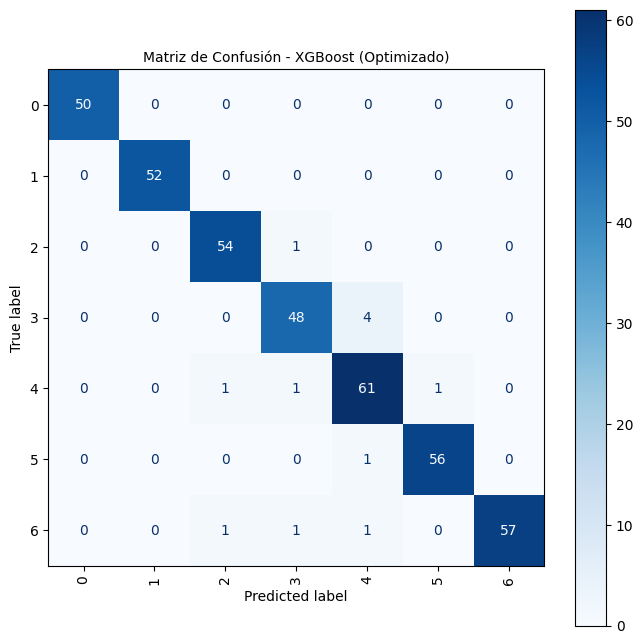

In [20]:
# Llamar a la función para el análisis final
mejor_modelo = evaluar_mejor_modelo(
    df_resultados=df_resultados_opt,
    pipelines=pipelines_optimizados,
    X_test=X_test,
    y_test=y_test
)

In [ ]:
import mlflow
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

def optimizar_con_mlflow(config_modelos, preprocesador, X_train, y_train, X_test, y_test):
    """
    Automatiza la optimización y el registro en MLflow de múltiples modelos.
    """
    # Establecer un nombre para el experimento general
    mlflow.set_experiment("Optimización de Clasificadores de Obesidad")

    resultados_optimizados = []
    mejores_pipelines = {}

    for config in config_modelos:
        nombre_modelo = config['nombre']
        print(f"--- Optimizando y Registrando: {nombre_modelo} ---")

        # Inicia una "corrida padre" para este modelo
        with mlflow.start_run(run_name=f"GridSearch_{nombre_modelo}", nested=True) as parent_run:
            mlflow.log_param("modelo", nombre_modelo)

            pipeline = Pipeline(steps=[
                ('preprocesador', preprocesador),
                ('clasificador', config['modelo'])
            ])

            grid_search = GridSearchCV(
                pipeline,
                config['parametros'],
                cv=5,
                scoring='f1_weighted',
                n_jobs=-1
            )
            grid_search.fit(X_train, y_train)

            # Registrar los mejores parámetros y el score del GridSearch
            mlflow.log_params(grid_search.best_params_)
            mlflow.log_metric("mejor_f1_cv", grid_search.best_score_)

            # Evaluar en el conjunto de prueba
            mejor_pipeline = grid_search.best_estimator_
            predicciones = mejor_pipeline.predict(X_test)
            accuracy = accuracy_score(y_test, predicciones)
            f1 = f1_score(y_test, predicciones, average='weighted')

            # Registrar métricas de prueba
            mlflow.log_metric("accuracy_test", accuracy)
            mlflow.log_metric("f1_test", f1)

            # Registrar el modelo para poder reutilizarlo después
            mlflow.sklearn.log_model(mejor_pipeline, f"modelo_{nombre_modelo.replace(' ', '_')}")

            # Guardar resultados para la tabla comparativa
            resultados_optimizados.append({
                'Modelo': nombre_modelo,
                'F1-Score (Test)': f1,
                'Accuracy (Test)': accuracy
            })
            mejores_pipelines[nombre_modelo] = mejor_pipeline

    return pd.DataFrame(resultados_optimizados), mejores_pipelines